[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/qmri_sg_challenge_2024_t2_star.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:qmri_sg_challenge_2024_t2_star.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebook]

# QMRI Challenge ISMRM 2024 - $T_2^*$ mapping

In [2]:
# Imports
import shutil
import tempfile
import time
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import zenodo_get
from mpl_toolkits.axes_grid1 import make_axes_locatable  # type: ignore [import-untyped]
from mrpro.algorithms.optimizers import adam
from mrpro.data import IData
from mrpro.operators.functionals import MSE
from mrpro.operators.models import MonoExponentialDecay

### Overview
The dataset consists of gradient echo images obtained at 11 different echo times, each saved in a separate DICOM file.
In order to obtain a $T_2^*$ map, we are going to:
- download the data from Zenodo
- read in the DICOM files (one for each echo time) and combine them in an IData object
- define a signal model (mono-exponential decay) and data loss (mean-squared error) function
- carry out a fit using ADAM from PyTorch

Everything is based on PyTorch, and therefore we can run the code either on the CPU or GPU. Simply set the flag below
to True to run the parameter estimation on the GPU.

In [3]:
flag_use_cuda = False

### Get data from Zenodo

In [4]:
data_folder = Path(tempfile.mkdtemp())
dataset = '10868361'
zenodo_get.zenodo_get([dataset, '-r', 5, '-o', data_folder])  # r: retries
with zipfile.ZipFile(data_folder / Path('T2star.zip'), 'r') as zip_ref:
    zip_ref.extractall(data_folder)

Title: Quantitative Study Group: T_2^*
Keywords: 
Publication date: 2024-03-25
DOI: 10.5281/zenodo.10868361
Total size: 445.8 kB

Link: https://zenodo.org/records/10868361/files/T2star.zip   size: 445.8 kB



Checksum is correct. (f387357a0b4024ca62e979203eff9def)
All files have been downloaded.


### Create image data (IData) object with different echo times

In [5]:
te_dicom_files = data_folder.glob('**/*.dcm')
idata_multi_te = IData.from_dicom_files(te_dicom_files)
# scaling the signal down to make the optimization easier
idata_multi_te.data[...] = idata_multi_te.data / 1500

# Move the data to the GPU
if flag_use_cuda:
    idata_multi_te = idata_multi_te.cuda()

if idata_multi_te.header.te is None:
    raise ValueError('Echo times need to be defined in the DICOM files.')

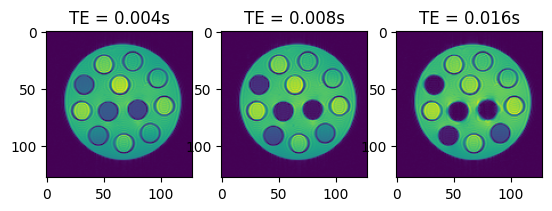

In [6]:
# Let's have a look at some of the images
fig, axes = plt.subplots(1, 3, squeeze=False)
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(torch.abs(idata_multi_te.data[idx, 0, 0, :, :]).cpu())
    ax.set_title(f'TE = {idata_multi_te.header.te[idx]:.3f}s')

### Signal model and loss function
We use the model $q$

$q(TE) = M_0 e^{-TE/T_2^*}$

with the equilibrium magnetization $M_0$, the echo time $TE$, and $T_2^*$

In [7]:
model = MonoExponentialDecay(decay_time=idata_multi_te.header.te)

As a loss function for the optimizer, we calculate the mean-squared error between the image data $x$ and our signal
model $q$.

In [8]:
mse = MSE(idata_multi_te.data)

Now we can simply combine the two into a functional which will then solve

$ \min_{M_0, T_2^*} ||q(M_0, T_2^*, TE) - x||_2^2$

In [9]:
functional = mse @ model

### Carry out fit

In [10]:
# The shortest echo time is a good approximation of the equilibrium magnetization
m0_start = torch.abs(idata_multi_te.data[torch.argmin(idata_multi_te.header.te), ...])
# 20 ms as a starting value for T2*
t2star_start = torch.ones(m0_start.shape, dtype=torch.float32, device=m0_start.device) * 20e-3

# Hyperparameters for optimizer
max_iter = 20000
lr = 1e-3

if flag_use_cuda:
    functional.cuda()

# Run optimization
start_time = time.time()
params_result = adam(functional, [m0_start, t2star_start], max_iter=max_iter, lr=lr)
print(f'Optimization took {time.time() - start_time}s')
m0, t2star = (p.detach() for p in params_result)
m0[torch.isnan(t2star)] = 0
t2star[torch.isnan(t2star)] = 0

Optimization took 44.555574893951416s


### Visualize the final results
To get an impression of how well the fit has worked, we are going to calculate the relative error between

$E_{relative} = \sum_{TE}\frac{|(q(M_0, T_2^*, TE) - x)|}{|x|}$

on a voxel-by-voxel basis.

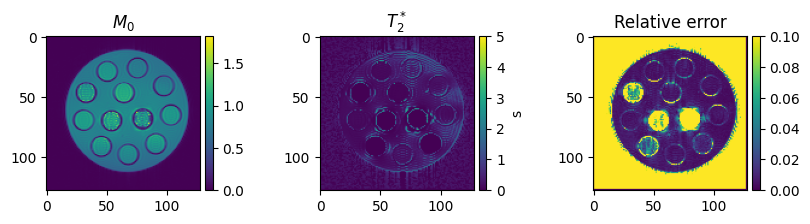

In [11]:
img_mult_te_abs_sum = torch.sum(torch.abs(idata_multi_te.data), dim=0)
relative_absolute_error = torch.sum(torch.abs(model(m0, t2star)[0] - idata_multi_te.data), dim=0) / (
    img_mult_te_abs_sum + 1e-9
)
fig, axes = plt.subplots(1, 3, figsize=(10, 2), squeeze=False)
colorbar_ax = [make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05) for ax in axes[0, :]]

im = axes[0, 0].imshow(m0[0, 0, ...].cpu())
axes[0, 0].set_title('$M_0$')
fig.colorbar(im, cax=colorbar_ax[0])

im = axes[0, 1].imshow(t2star[0, 0, ...].cpu(), vmin=0, vmax=5)
axes[0, 1].set_title('$T_2^*$')
fig.colorbar(im, cax=colorbar_ax[1], label='s')

im = axes[0, 2].imshow(relative_absolute_error[0, 0, ...].cpu(), vmin=0, vmax=0.1)
axes[0, 2].set_title('Relative error')
fig.colorbar(im, cax=colorbar_ax[2])

In [12]:
# Clean-up by removing temporary directory
shutil.rmtree(data_folder)